In [1]:
from scipy.stats import skew
import scipy.optimize as op
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import re
import os
import sys

def extract_lightcurve_data(parent_dir="./"):

    # Define the list of classes (folder names)
    classes = ["Planetary_systems", "single lens", "binary lens"]
    
    # Define the list of bands
    bands = ["w", "g", "r", "i", "z"]
    
    # Define the zeroth magnitudes for each band
    zeroth_magnitudes = {
        "w": 27.6,
        "g": 25.0,
        "r": 24.7,
        "i": 24.0,
        "z": 23.3
    }
    
    # Initialize an empty list to store data
    data_list = []
    
    # Iterate through each folder
    for cls in classes:
        folder_path = os.path.join(parent_dir, cls)  # Construct the full path to the folder
        
        # Check if the folder exists
        if not os.path.isdir(folder_path):
            continue
        
        # Iterate through all files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".txt"):  # Ensure it's a text file
                file_path = os.path.join(folder_path, file_name)
                
                # Read the file
                with open(file_path, "r") as f:
                    lines = f.readlines()
                    
                    # Extract the number from the "Source" line
                    number = None
                    for line in lines:
                        if "Source" in line:
                            number = line.split(":")[-1].strip()
                            break  # Stop searching once the number is found
                    
                    # Extract baseline magnitudes
                    baseline_magnitudes = {}
                    for line in lines:
                        match = re.match(r"(\w):([\d.]+)-", line.strip())
                        if match:
                            band, baseline_mag = match.groups()
                            baseline_magnitudes[f"baselinemag_{band}"] = float(baseline_mag)
                    
                    # Append data for each band
                    for band in bands:
                        data_list.append({
                            "Class": cls,
                            "Source": number,
                            "File": file_name,
                            "Band": band,
                            "baseline_magnitude": baseline_magnitudes.get(f"baselinemag_{band}", None),
                            "zeroth_magnitude": zeroth_magnitudes.get(band, None)
                        })
    

    df = pd.DataFrame(data_list)


    
    return df


def get_time_magnification(df, index=0):

    # Select the specified row
    selected_row = df.iloc[index]

    # Extract file path and band information
    file_path = f"{selected_row['Class']}/{selected_row['File']}"
    selected_band = selected_row["Band"]
    baseline_magnitude = selected_row["baseline_magnitude"]
    zeroth_magnitude = selected_row["zeroth_magnitude"]

    # Read the corresponding data file
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Find the start of the data table
    start_index = None
    for i, line in enumerate(lines):
        if line.strip().startswith("band,mjd,mag,magerr,m5"):
            start_index = i + 1
            break

    if start_index is None:
        raise ValueError("Data header not found in the file.")

    # Read the data into a DataFrame
    data = [line.strip().split(", ") for line in lines[start_index:]]
    df_data = pd.DataFrame(data, columns=["band", "mjd", "mag", "magerr", "m5"])

    # Convert numeric columns to float
    df_data[["mjd", "mag", "magerr", "m5"]] = df_data[["mjd", "mag", "magerr", "m5"]].astype(float)

    # Filter the DataFrame for the selected band
    df_filtered = df_data[df_data["band"] == selected_band]

    # Compute flux and baseline flux
    df_filtered["flux"] = 10 ** (0.4 * (zeroth_magnitude - df_filtered["mag"]))
    baseline_flux = 10 ** (0.4 * (zeroth_magnitude - baseline_magnitude))

    # Compute magnification
    df_filtered["magnification"] = df_filtered["flux"] / baseline_flux

    return df_filtered["mjd"], df_filtered[ "magnification"]


def filter_days(time, magnification, index, df, days=5, thresh_mag=1.01):

    cadence = time.iloc[1] - time.iloc[0]
    n_points = int(days / cadence)

    # Select points above threshold - get boolean mask
    mask = magnification > thresh_mag
    valid_indices = np.where(mask)[0]

    if len(valid_indices) < n_points:
        df.drop(index, inplace=True)
        df.reset_index(drop=True, inplace=True)
        return None  # Skip this index in parallel


    time_filtered = time.iloc[valid_indices][:n_points]
    magnification_filtered = magnification.iloc[valid_indices][:n_points]

    return time_filtered, magnification_filtered



def plot_magnification(time, magnification, df, index):

    label = df['Class'][index]
    band = df['Band'][index]
    source = df['Source'][index]
    
    plt.figure(figsize=(8, 5))
    plt.scatter(time, magnification, color='b', s=10, alpha=0.7, label="Magnification")
    
    plt.xlabel("Time (days)")
    plt.ylabel("Magnification")
    plt.title(f"{label} for source number {source} in {band} band")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    
    plt.show()


def pspl_fun(t, t0, tE, u0, fs):
        """
        PSPL model function to calculate magnification as a function of time.
        """
        u = np.sqrt(u0**2 + ((t - t0) / tE) ** 2)
        A = ((u ** 2) + 2) / (u * np.sqrt(u ** 2 + 4))
        F = fs * A + (1 - fs)
        return F

def lnlike(theta, t, f, f_err):
    """
    Log-likelihood function for fitting the PSPL model.
    """
    t0, tE, u0, fs = theta
    model = pspl_fun(t, t0, tE, u0, fs)
    inv_sigma2 = 1.0 / (f_err ** 2)
    return -0.5 * np.sum((f - model) ** 2 * inv_sigma2)

def pspl_fit(time_filtered, magnification_filtered, index, df):
    t0_guess = time_filtered[np.argmax(magnification_filtered)]  # Guess for t0
    tE_guess = [1, 20]  # Guess for tE
    u0_true = 1.0 / np.max(magnification_filtered)  # Guess for u0
    blending = 0.5  # Guess for fs

    merr = np.ones(len(magnification_filtered)) * 0.001  # Assuming small error
    
    # Define the negative log-likelihood function for optimization
    nll = lambda *args: -lnlike(*args)
    
    best_result = None
    chi2_best = np.inf
    for tE in tE_guess:
        res_scipy = op.minimize(nll, [t0_guess, tE, u0_true, blending],
                                args=(time_filtered, magnification_filtered, merr), method='Nelder-Mead')
        if res_scipy['fun'] < chi2_best:
            chi2_best = res_scipy['fun']
            best_result = res_scipy.x
    
    # Extract the best parameters from the result
    t0_best, tE_best, u0_best, blending_best = best_result
    

    df.loc[index, 't0'] = t0_best
    df.loc[index, 'tE'] = tE_best
    df.loc[index, 'u0'] = u0_best
    df.loc[index, 'blending'] = blending_best
    df.loc[index, 'chi2'] = chi2_best
    
    return df



def plot_pspl(time_filtered, magnification_filtered, index, df):
    
        label = df['Class'][index]
        band = df['Band'][index]
        source = df['Source'][index]

        plt.figure(figsize=(8, 5))
    
        # Plot the observed magnification data
        plt.scatter(time_filtered, magnification_filtered, s=10, label="Observed Magnification")

        # Plot the PSPL model based on the parameters from the dataframe
        pspl_model = pspl_fun(time_filtered, df['t0'][index], df['tE'][index], df['u0'][index], df['blending'][index])
        plt.plot(time_filtered, pspl_model, label="PSPL Model", linestyle='--', color='red')
    

        plt.xlabel("Time (days)")
        plt.ylabel("Magnification")
        plt.title(f"{label} for source number {source} in {band} band")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)
    

        plt.show()




def residuals(time_filtered, magnification_filtered, index, df):
        residuals = magnification_filtered - pspl_fun(time_filtered, df['t0'][index], df['tE'][index], df['u0'][index], df['blending'][index])
        
        
        residual_mean = np.mean(residuals)
        residual_median = np.median(residuals)
        residual_std = np.std(residuals)


        df.loc[index, 'residual_mean'] = residual_mean
        df.loc[index, 'residual_median'] = residual_median
        df.loc[index, 'residual_std'] = residual_std


        return df, residuals




def residuals_bin(time_filtered, magnification_filtered, index, residuals, df):
    bin_size = 10  # Number of residuals per bin
    num_bins = len(residuals) // bin_size  # Total number of bins

    # Truncate residuals to ensure divisibility by bin_size
    residuals_truncated = residuals[:num_bins * bin_size]

    # Convert residuals to a numpy array and reshape into bins of `bin_size`
    residuals_binned = np.array(residuals_truncated).reshape(num_bins, bin_size)

    # Compute statistics across bins
    bin_means = np.mean(residuals_binned, axis=1)
    bin_medians = np.median(residuals_binned, axis=1)
    bin_stds = np.std(residuals_binned, axis=1)


    df.loc[index, 'residual_bin_mean'] = np.mean(bin_means)
    df.loc[index, 'residual_bin_median'] = np.median(bin_medians)
    df.loc[index, 'residual_bin_std'] = np.std(bin_stds)

    return df



def fit_Cheby(time_filtered, magnification_filtered, index, df, degree=50):
        n =degree

        y_values = magnification_filtered
        mjd_t = time_filtered
    
        if n <11:
            print('Degree must be more than 10.')
            sys.exit()
        xmin = min(mjd_t)
        xmax = max(mjd_t)
        bma = 0.5 * (xmax - xmin)
        bpa = 0.5 * (xmax + xmin)
        interpoll = interp1d(mjd_t, y_values, kind='cubic')
        f = [interpoll(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
        fac = 2.0 / n
        cheby_coefficients = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n) for k in range(n)]) for j in range(n)]
    
    
        Cheby_all = {}
        Cheby_func = []
    
        for t_i in np.sort(mjd_t):
    
            y = (2.0 * t_i - xmin - xmax) * (1.0 / (xmax - xmin))
            y2 = 2.0 * y
            (d, dd) = (cheby_coefficients[-1], 0)             # Special case first step for efficiency
    
            for cj in cheby_coefficients[-2:0:-1]:            # Clenshaw's recurrence
                (d, dd) = (y2 * d - dd + cj, d)
            Cheby_func.append(y * d - dd + 0.5 * cheby_coefficients[0])
    
        Cheby_all['y_fitted'] = np.asarray(Cheby_func)


        Cheby_all['Cheby_a0'] = (cheby_coefficients[0])/(cheby_coefficients[0])
        Cheby_all['Cheby_a2'] = (cheby_coefficients[2])/(cheby_coefficients[0])
        Cheby_all['Cheby_a4'] = (cheby_coefficients[4])/(cheby_coefficients[0])
        Cheby_all['Cheby_a6'] = (cheby_coefficients[6])/(cheby_coefficients[0])
        Cheby_all['Cheby_a8'] = (cheby_coefficients[8])/(cheby_coefficients[0])
        Cheby_all['Cheby_a10'] = (cheby_coefficients[10])/(cheby_coefficients[0])
    
    
        Cheby_all['Cheby_cj_sqr'] = np.sum((np.asarray(cheby_coefficients)/(cheby_coefficients[0]))**2)
        Cheby_all['log10_Cheby_cj_sqr_minus_one'] = np.log10(Cheby_all['Cheby_cj_sqr'] - 1)
        Cheby_all['pos_log10_Cheby_cj_sqr_minus_one'] = -1*np.log10(Cheby_all['Cheby_cj_sqr'] - 1)
        Cheby_all['delta_A_chebyshev_sqr'] = np.sum((y_values - Cheby_func)**2)



        df.loc[index, 'Cheby_a0'] = Cheby_all['Cheby_a0']
        df.loc[index, 'Cheby_a2'] = Cheby_all['Cheby_a2']
        df.loc[index, 'Cheby_a4'] = Cheby_all['Cheby_a4']
        df.loc[index, 'Cheby_a6'] = Cheby_all['Cheby_a6']
        df.loc[index, 'Cheby_a8'] = Cheby_all['Cheby_a8']
        df.loc[index, 'Cheby_a10'] = Cheby_all['Cheby_a10']
        df.loc[index, 'Cheby_cj_sqr'] = Cheby_all['Cheby_cj_sqr']
        df.loc[index, 'pos_log10_Cheby_cj_sqr_minus_one'] = Cheby_all['pos_log10_Cheby_cj_sqr_minus_one']
        df.loc[index, 'log10_Cheby_cj_sqr_minus_one'] = Cheby_all['log10_Cheby_cj_sqr_minus_one']
        df.loc[index, 'delta_A_chebyshev_sqr'] = Cheby_all['delta_A_chebyshev_sqr']

        return df, Cheby_all['y_fitted']


def plot_cheby(time_filtered, magnification_filtered, index, cheby_y, df):

        label = df['Class'][index]
        band = df['Band'][index]
        source = df['Source'][index]


        plt.figure(figsize=(8, 5))
        # Plot the observed magnification data
        plt.scatter(time_filtered, magnification_filtered, s=10, label="Observed Magnification")
    
        # Plot the Chebyshev fit
        plt.plot(time_filtered, cheby_y, label="Chebyshev_fit", linestyle='--', color='red')
    

        plt.xlabel("Time (days)")
        plt.ylabel("Magnification")
        plt.title(f"{label} for source number {source} in {band} band")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)

        plt.show()


def calculate_skewness(magnification_filtered, index, df):
        # Calculate skewness of the magnification data
        skewness_value = skew(magnification_filtered)
        

        df.loc[index, 'skewness'] = skewness_value
        return df


def calculate_von_neumann(magnification_filtered, index, df):
    differences = np.diff(magnification_filtered)  # Compute differences along time axis
    sum_squared_diff = np.sum(differences ** 2) / (len(magnification_filtered) - 1)  # Sum and normalize
    variance = np.var(magnification_filtered, ddof=0)  # Variance per row
    eta_values = sum_squared_diff / variance
    

    df.loc[index, 'von_neumann'] = eta_values 
    
    return df



In [5]:
df = extract_lightcurve_data("./")
df

,Class,Source,File,Band,baseline_magnitude,zeroth_magnitude
0,Planetary_systems,138,Event_138.txt,w,20.9838,27.6
1,Planetary_systems,138,Event_138.txt,g,23.1690,25.0
2,Planetary_systems,138,Event_138.txt,r,22.0010,24.7
3,Planetary_systems,138,Event_138.txt,i,21.4360,24.0
4,Planetary_systems,138,Event_138.txt,z,21.1530,23.3
...,...,...,...,...,...,...
495,Planetary_systems,445,Event_445.txt,w,21.1398,27.6
496,Planetary_systems,445,Event_445.txt,g,23.5370,25.0
497,Planetary_systems,445,Event_445.txt,r,22.3530,24.7
498,Planetary_systems,445,Event_445.txt,i,21.6720,24.0


/var/folders/87/r1wgt2jx19nf09r5jgrt58vh0000gn/T/ipykernel_27503/4102992681.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["flux"] = 10 ** (0.4 * (zeroth_magnitude - df_filtered["mag"]))
/var/folders/87/r1wgt2jx19nf09r5jgrt58vh0000gn/T/ipykernel_27503/4102992681.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["magnification"] = df_filtered["flux"] / baseline_flux


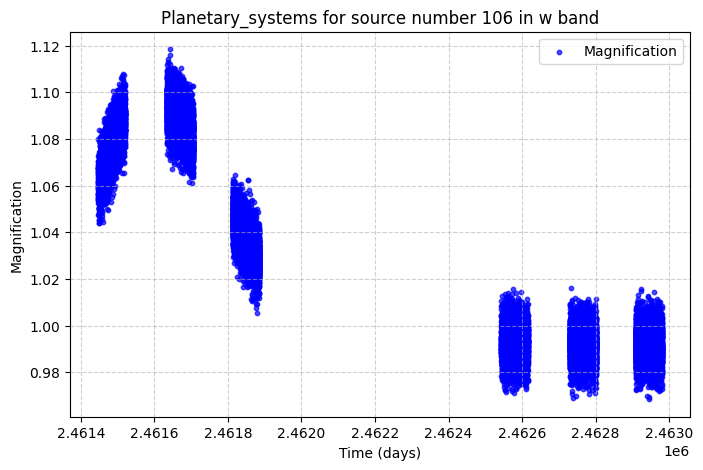

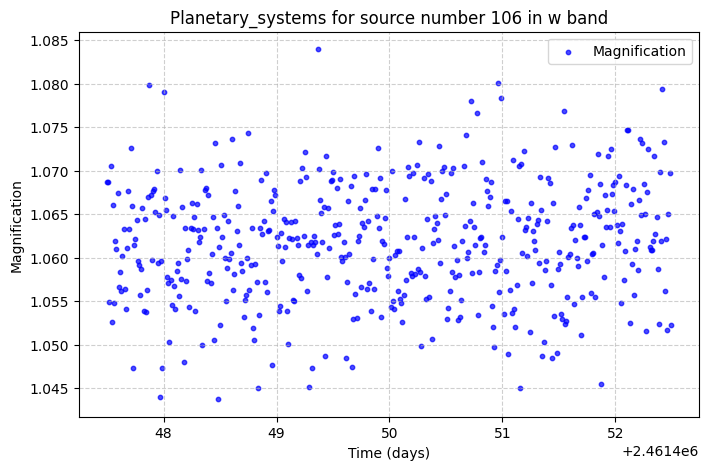

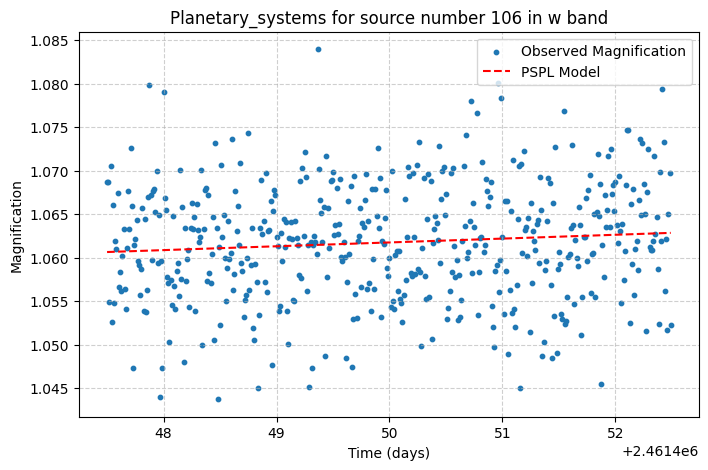

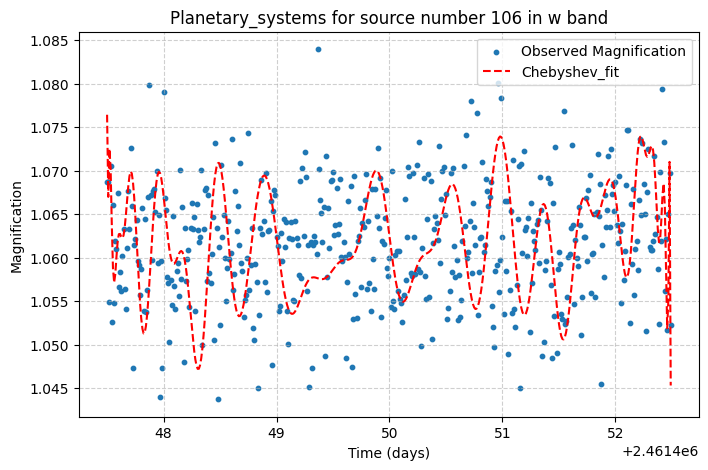

In [10]:
from scipy.stats import skew
import scipy.optimize as op
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import re





index=30

df = extract_lightcurve_data("./")
time, magnification = get_time_magnification(df, index)

plot_magnification(time, magnification, df, index)

result = filter_days(time, magnification, index, df, days=5, thresh_mag=1.01)
if result is not None:
    time_filtered, magnification_filtered = result
else:
    print("Skipping index 0 due to insufficient data points.")


plot_magnification(time_filtered, magnification_filtered, df, index)


df = pspl_fit(time_filtered, magnification_filtered, index, df)

plot_pspl(time_filtered, magnification_filtered, index,df)

df , residual = residuals(time_filtered, magnification_filtered, index, df)
df = residuals_bin(time_filtered, magnification_filtered, index, residual, df)


df, cheby_y = fit_Cheby(time_filtered, magnification_filtered, index, df, degree=50)

plot_cheby(time_filtered, magnification_filtered, index, cheby_y, df)

df =calculate_skewness(magnification_filtered, index, df)
df =calculate_von_neumann(magnification_filtered, index, df)


In [11]:
df.iloc[index]

Class                               Planetary_systems
Source                                            106
File                                    Event_106.txt
Band                                                w
baseline_magnitude                            20.8618
zeroth_magnitude                                 27.6
t0                                     2461574.142388
tE                                         118.529351
u0                                          -1.553033
blending                                      0.84329
chi2                                     10732.514821
residual_mean                                0.000009
residual_median                              0.000143
residual_std                                 0.006687
residual_bin_mean                            0.000009
residual_bin_median                          0.000556
residual_bin_std                              0.00157
Cheby_a0                                          1.0
Cheby_a2                    